# The YUSAG Football Model
    by Matt Robinson, matthew.robinson@yale.edu, Yale Undergraduate Sports Analytics Club
    
This notebook introduces the model we at the Yale Undergraduate Sports Analytics Group (YUSAG) use for our college football rankings. This specific notebook details our FCS rankings at the beginning of the 2017 season.


In [1]:
import numpy as np
import pandas as pd
import math

Let's start by reading in the NCAA FCS football data from 2013-2016:

In [2]:
df_1 = pd.read_csv('NCAA_FCS_Results_2013_.csv')
df_2 = pd.read_csv('NCAA_FCS_Results_2014_.csv')
df_3 = pd.read_csv('NCAA_FCS_Results_2015_.csv')
df_4 = pd.read_csv('NCAA_FCS_Results_2016_.csv')

df = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)

In [3]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1
0,2013,9,21,Abilene Christian,Illinois St.,V,17,31,NaN,2
1,2013,10,12,Abilene Christian,Houston Baptist,V,69,12,NaN,2
2,2013,10,19,Abilene Christian,Incarnate Word,H,40,6,NaN,2
3,2013,11,9,Abilene Christian,Incarnate Word,V,31,34,NaN,2
4,2013,11,16,Abilene Christian,Prairie View,V,65,45,NaN,2


As you can see, the `OT` column has some `NaN` values that we will replace with 0.

In [4]:
# fill missing data with 0
df = df.fillna(0)

In [5]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1
0,2013,9,21,Abilene Christian,Illinois St.,V,17,31,0.0,2
1,2013,10,12,Abilene Christian,Houston Baptist,V,69,12,0.0,2
2,2013,10,19,Abilene Christian,Incarnate Word,H,40,6,0.0,2
3,2013,11,9,Abilene Christian,Incarnate Word,V,31,34,0.0,2
4,2013,11,16,Abilene Christian,Prairie View,V,65,45,0.0,2


I'm also going to make some weights for when we run our linear regression. I have found that using the factorial of the difference between the year and 2012 seems to work decently well. Clearly, the most recent seasons are weighted quite heavily in this scheme.

In [6]:
# update the weights based on a factorial scheme
df['weights'] = (df['year']-2012)
df['weights'] = df['weights'].apply(lambda x: math.factorial(x))

And now, we also are going to make a `scorediff` column that we can use in our linear regression.

In [7]:
df['scorediff'] = (df['teamscore']-df['oppscore'])

In [8]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1,weights,scorediff
0,2013,9,21,Abilene Christian,Illinois St.,V,17,31,0.0,2,1,-14
1,2013,10,12,Abilene Christian,Houston Baptist,V,69,12,0.0,2,1,57
2,2013,10,19,Abilene Christian,Incarnate Word,H,40,6,0.0,2,1,34
3,2013,11,9,Abilene Christian,Incarnate Word,V,31,34,0.0,2,1,-3
4,2013,11,16,Abilene Christian,Prairie View,V,65,45,0.0,2,1,20


Since we need numerical values for the linear regression algorithm, I am going to replace the locations with what seem like reasonable numbers:
* Visiting = -1
* Neutral = 0
* Home = 1

The reason we picked these exact numbers will become clearer in a little bit.

In [9]:
df['location'] = df['location'].replace('V',-1)
df['location'] = df['location'].replace('N',0)
df['location'] = df['location'].replace('H',1)

In [10]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1,weights,scorediff
0,2013,9,21,Abilene Christian,Illinois St.,-1,17,31,0.0,2,1,-14
1,2013,10,12,Abilene Christian,Houston Baptist,-1,69,12,0.0,2,1,57
2,2013,10,19,Abilene Christian,Incarnate Word,1,40,6,0.0,2,1,34
3,2013,11,9,Abilene Christian,Incarnate Word,-1,31,34,0.0,2,1,-3
4,2013,11,16,Abilene Christian,Prairie View,-1,65,45,0.0,2,1,20


The way our linear regression model works is a little tricky to code up in scikit-learn. It's much easier to do in R, but then you don't have a full understanding of what's happening when we make the model.

In simplest terms, our model predicts the score differential (`scorediff`) of each game based on three things: the strength of the `team`, the strength of the `opponent`, and the `location`.

You'll notice that the `team` and `opponent` features are categorical, and thus are not curretnly ripe for use with linear regression. However, we can use what is called 'one hot encoding' in order to transform these features into a usable form. One hot encoding works by taking the `team` feature, for example, and transforming it into many features such as `team_Yale` and `team_Harvard`. This `team_Yale` feature will usally equal zero, except when the team is actually Yale, then `team_Yale` will equal 1. In this way, it's a binary encoding (which is actually very useful for us as we'll see later).

One can use `sklearn.preprocessing.OneHotEncoder` for this task, but I am going to use Pandas instead: 

In [11]:
# create dummy variables, need to do this in python b/c does not handle automatically like R
team_dummies = pd.get_dummies(df.team, prefix='team')
opponent_dummies = pd.get_dummies(df.opponent, prefix='opponent')

df = pd.concat([df, team_dummies, opponent_dummies], axis=1)

In [12]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1,...,opponent_Valparaiso,opponent_Villanova,opponent_Wagner,opponent_Weber St.,opponent_Western Caro.,opponent_Western Ill.,opponent_William & Mary,opponent_Wofford,opponent_Yale,opponent_Youngstown St.
0,2013,9,21,Abilene Christian,Illinois St.,-1,17,31,0.0,2,...,0,0,0,0,0,0,0,0,0,0
1,2013,10,12,Abilene Christian,Houston Baptist,-1,69,12,0.0,2,...,0,0,0,0,0,0,0,0,0,0
2,2013,10,19,Abilene Christian,Incarnate Word,1,40,6,0.0,2,...,0,0,0,0,0,0,0,0,0,0
3,2013,11,9,Abilene Christian,Incarnate Word,-1,31,34,0.0,2,...,0,0,0,0,0,0,0,0,0,0
4,2013,11,16,Abilene Christian,Prairie View,-1,65,45,0.0,2,...,0,0,0,0,0,0,0,0,0,0


Now let's make our training data, so that we can construct the model. At this point, I am going to use all the avaiable data to train the model, using our predetermined hyperparameters. This way, the model is ready to make predictions for the 2017 season.

In [13]:
# make the training data
X = df.drop(['year','month','day','team','opponent','teamscore','oppscore','D1','OT','weights','scorediff'], axis=1)
y = df['scorediff']
weights = df['weights']

In [14]:
X.head()

,location,team_Abilene Christian,team_Alabama A&M,team_Alabama St.,team_Albany (NY),team_Alcorn,team_Ark.-Pine Bluff,team_Austin Peay,team_Bethune-Cookman,team_Brown,...,opponent_Valparaiso,opponent_Villanova,opponent_Wagner,opponent_Weber St.,opponent_Western Caro.,opponent_Western Ill.,opponent_William & Mary,opponent_Wofford,opponent_Yale,opponent_Youngstown St.
0,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y.head()

0   -14
1    57
2    34
3    -3
4    20
Name: scorediff, dtype: int64

In [16]:
weights.head()

0    1
1    1
2    1
3    1
4    1
Name: weights, dtype: int64

Now let's train the linear regression model. You'll notice that I'm actually using ridge regression (adds an l2 penalty with alpha = 1.0) because that prevents the model from overfitting and also limits the values of the coefficients to be more interpretable. If I did not add this penalty, the coefficients would be huge.

In [17]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(X, y, sample_weight=weights)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
# get the R^2 value
r_squared = ridge_reg.score(X, y, sample_weight=weights)
print('R^2 on the training data:')
print(r_squared)

R^2 on the training data:
0.566012746279


Now that the model is trained, we can use it to provide our rankings. Note that in this model, a team's ranking is simply defined as its linear regression coefficient, which we call the YUSAG coefficient. 

When predicting a game's score differential on a neutral field, the predicted score differential (`scorediff`) is just the difference in YUSAG coefficients. The reason this works is the binary encoding we did earlier.

#### More details below on how it actually works

Ok, so you may have noticed that every game in our dataframe is actually duplicated, just with the `team` and `opponent` variables switched. This may have seemed like a mistake but it is actually useful for making the model more interpretable. 

When we run the model, we get a coefficient for the `team_Yale` variable, which we call the YUSAG coefficient, and a coefficient for the `opponent_Yale` variable. Since we allow every game to be repeated, these variables end up just being negatives of each other. 

So let's think about what we are doing when we predict the score differential for the Harvard-Penn game with `team` = Harvard and `opponent` = Penn.

In our model, the coefficients are as follows:
- team_Harvard_coef = 7.78
- opponent_Harvard_coef = -7.78
- team_Penn_coef = 6.68
- opponent_Penn_coef = -6.68

when we go to use the model for this game, it looks like this:

`scorediff` = (location_coef $*$ `location`) + (team_Harvard_coef $*$ `team_Harvard`) + (opponent_Harvard_coef $*$ `opponent_Harvard`) + (team_Penn_coef $*$ `team_Penn`) + (opponent_Penn_coef $*$ `opponent_Penn`) + (team_Yale_coef $*$ `team_Yale`) + (opponent_Yale_coef $*$ `opponent_Yale`) + $\cdots$

where the $\cdots$ represent data for many other teams, which will all just equal $0$.

To put numbers in for the variables, the model looks like this:

`scorediff` = (location_coef $*$ $0$) + (team_Harvard_coef $*$ $1$) + (opponent_Harvard_coef $*$ $0$) + (team_Penn_coef $*$ $0$) + (opponent_Penn_coef $*$ $1$) + (team_Yale_coef $*$ $0$) + (opponent_Yale_coef $*$ $0$) + $\cdots$

Which is just:

`scorediff` = (location_coef $*$ $0$) + (7.78 $*$ $1$) + (-6.68 $*$ $1$) = $7.78 - 6.68$ = Harvard_YUSAG_coef - Penn_YUSAG_coef

Thus showing how the difference in YUSAG coefficients is the same as the predicted score differential. Furthermore, the higher YUSAG coefficient a team has, the better they are.

Lastly, if the Harvard-Penn game was to be home at Harvard, we would just add the location_coef:

`scorediff` = (location_coef $*$ $1$) + (team_Harvard_coef $*$ $1$) + (opponent_Penn_coef $*$ $1$) = $1.77 + 7.78 - 6.68$ = Location_coef + Harvard_YUSAG_coef - Penn_YUSAG_coef


In [19]:
# get the coefficients for each feature
coef_data = list(zip(X.columns,ridge_reg.coef_))
coef_df = pd.DataFrame(coef_data,columns=['feature','feature_coef'])
coef_df.head()

,feature,feature_coef
0,location,1.774815
1,team_Abilene Christian,-9.894031
2,team_Alabama A&M,-24.774511
3,team_Alabama St.,-20.492633
4,team_Albany (NY),8.625223


Let's get only the team variables, so that it is a proper ranking

In [20]:
# first get rid of opponent_ variables
team_df = coef_df[~coef_df['feature'].str.contains("opponent")]

# get rid of the location variable
team_df = team_df.iloc[1:]

In [21]:
team_df.head()

,feature,feature_coef
1,team_Abilene Christian,-9.894031
2,team_Alabama A&M,-24.774511
3,team_Alabama St.,-20.492633
4,team_Albany (NY),8.625223
5,team_Alcorn,-7.798656


In [22]:
# rank them by coef, not alphabetical order
ranked_team_df = team_df.sort_values(['feature_coef'],ascending=False)
# reset the indices at 0
ranked_team_df = ranked_team_df.reset_index(drop=True);

In [23]:
ranked_team_df.head()

,feature,feature_coef
0,team_James Madison,33.913687
1,team_North Dakota St.,31.681034
2,team_UNI,24.165642
3,team_Eastern Wash.,23.687390
4,team_South Dakota St.,22.873590


I'm goint to change the name of the columns and remove the 'team_' part of every string:

In [24]:
ranked_team_df.rename(columns={'feature':'team', 'feature_coef':'YUSAG_coef'}, inplace=True)
ranked_team_df['team'] = ranked_team_df['team'].str.replace('team_', '')

In [25]:
ranked_team_df.head()

,team,YUSAG_coef
0,James Madison,33.913687
1,North Dakota St.,31.681034
2,UNI,24.165642
3,Eastern Wash.,23.687390
4,South Dakota St.,22.873590


Lastly, I'm just going to shift the index to start at 1, so that it corresponds to the ranking.

In [26]:
ranked_team_df.index = ranked_team_df.index + 1 

Now save it to a csv file

In [27]:
ranked_team_df.to_csv("FCS_power_rankings.csv")

Let's also look at the Ivy league teams specifically:

In [28]:
ivy_team_names = ['Yale','Harvard','Princeton','Cornell','Brown','Columbia','Dartmouth','Penn']
ivy_ranked_team_df = ranked_team_df[ranked_team_df['team'].isin(ivy_team_names)]

In [29]:
ivy_ranked_team_df

,team,YUSAG_coef
20,Princeton,13.971680
40,Harvard,7.776762
42,Penn,6.876865
55,Dartmouth,4.592076
83,Yale,-4.979445
85,Brown,-6.045899
88,Columbia,-6.883165
94,Cornell,-7.825878


Let's also save this to a csv file:

In [30]:
ivy_ranked_team_df.to_csv("IVY_power_rankings.csv")

## Additional stuff: Testing the model

This section is mostly about how one could test the performance of the model or how one could choose appropriate hyperparamters.

#### Creating a new dataframe

First let's take the original dataframe and sort it by date, so that the order of games in the dataframe matches the order the games were played.

In [31]:
# sort by date and reset the indices to 0
df_dated = df.sort_values(['year', 'month','day'], ascending=[True, True, True])
df_dated = df_dated.reset_index(drop=True)

In [32]:
df_dated.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1,...,opponent_Valparaiso,opponent_Villanova,opponent_Wagner,opponent_Weber St.,opponent_Western Caro.,opponent_Western Ill.,opponent_William & Mary,opponent_Wofford,opponent_Yale,opponent_Youngstown St.
0,2013,8,29,Central Ark.,Incarnate Word,1,58,7,0.0,2,...,0,0,0,0,0,0,0,0,0,0
1,2013,8,29,Chattanooga,UT Martin,1,21,31,0.0,2,...,0,0,0,0,0,0,0,0,0,0
2,2013,8,29,Dayton,Youngstown St.,-1,10,28,0.0,2,...,0,0,0,0,0,0,0,0,0,1
3,2013,8,29,Delaware,Jacksonville,1,51,35,0.0,2,...,0,0,0,0,0,0,0,0,0,0
4,2013,8,29,Eastern Ky.,Robert Morris,1,38,6,0.0,2,...,0,0,0,0,0,0,0,0,0,0


Let's initially make a dataframe with training data (the first three years of results)

In [33]:
thirteen_df = df_dated.loc[df_dated['year']==2013]
fourteen_df = df_dated.loc[df_dated['year']==2014]
fifteen_df = df_dated.loc[df_dated['year']==2015]

train_df = pd.concat([thirteen_df,fourteen_df,fifteen_df], ignore_index=True)

Now let's also make an initial testing dataframe with the data from this past year.

In [34]:
sixteen_df = df_dated.loc[df_dated['year']==2016]
seventeen_df = df_dated.loc[df_dated['year']==2017]

test_df = pd.concat([sixteen_df,seventeen_df], ignore_index=True)

I am now going to set up a testing/validation scheme for the model. It works like this:

First I start off where my training data is all games from 2012-2015. Using the model trained on this data, I then predict games from the first week of the 2016 season and look at the results.

Next, I add that first week's worth of games to the training data, and now I train on all 2012-2015 results plus the first week from 2016. After training the model on this data, I then test on the second week of games. I then add that week's games to the training data and repeat the same procedure week after week.

In this way, I am never testing on a result that I have trained on. Though, it should be noted that I have also used this as a validation scheme, so I have technically done some sloppy 'data snooping' and this is not a great predictor of my generalization error. 

In [35]:
def train_test_model(train_df, test_df):

    # make the training data
    X_train = train_df.drop(['year','month','day','team','opponent','teamscore','oppscore','D1','OT','weights','scorediff'], axis=1)
    y_train = train_df['scorediff']
    weights_train = train_df['weights']
    
    # train the model
    ridge_reg = Ridge()
    ridge_reg.fit(X_train, y_train, weights_train)
    fit = ridge_reg.score(X_train,y_train,sample_weight=weights_train)
    print('R^2 on the training data:')
    print(fit)
    
    # get the test data
    X_test = test_df.drop(['year','month','day','team','opponent','teamscore','oppscore','D1','OT','weights','scorediff'], axis=1)
    y_test = test_df['scorediff']
    
    # get the metrics
    compare_data = list(zip(ridge_reg.predict(X_test),y_test))
    
    right_count = 0
    for tpl in compare_data:
        if tpl[0] >= 0 and tpl[1] >=0:
            right_count = right_count + 1
        elif tpl[0] <= 0 and tpl[1] <=0:
            right_count = right_count + 1
    accuracy = right_count/len(compare_data)
    print('accuracy on this weeks games')
    print(right_count/len(compare_data))
    
    total_squared_error = 0.0
    for tpl in compare_data:
        total_squared_error = total_squared_error + (tpl[0]-tpl[1])**2
    RMSE = (total_squared_error / float(len(compare_data)))**(0.5)
    print('RMSE on this weeks games:')
    print(RMSE)
    
    return fit, accuracy, RMSE, right_count, total_squared_error
     

In [36]:
#Now the code for running the week by week testing.
base_df = train_df
new_indices = []
# this is the hash for the first date
last_date_hash = 2026

fit_list = []
accuracy_list = []
RMSE_list = []
total_squared_error = 0
total_right_count = 0

for index, row in test_df.iterrows():
    
    year = row['year']
    month = row['month']
    day = row['day']
    date_hash = year+month+day 
    
    if date_hash != last_date_hash:
        last_date_hash = date_hash
        test_week = test_df.iloc[new_indices]
        fit, accuracy, RMSE, correct_calls, squared_error = train_test_model(base_df,test_week)
        
        fit_list.append(fit)
        accuracy_list.append(accuracy)
        RMSE_list.append(RMSE)
        
        total_squared_error = total_squared_error + squared_error
        total_right_count = total_right_count + correct_calls
        
        base_df = pd.concat([base_df,test_week],ignore_index=True)
        new_indices = [index]
        
    else:
        new_indices.append(index)

R^2 on the training data:
0.592540740738
accuracy on this weeks games
1.0
RMSE on this weeks games:
19.4241759023
R^2 on the training data:
0.59319110015
accuracy on this weeks games
1.0
RMSE on this weeks games:
17.0479673507
R^2 on the training data:
0.591611403012
accuracy on this weeks games
1.0
RMSE on this weeks games:
11.2788317764
R^2 on the training data:
0.605692833023
accuracy on this weeks games
0.0
RMSE on this weeks games:
18.3944877773
R^2 on the training data:
0.604525852416
accuracy on this weeks games
0.75
RMSE on this weeks games:
22.7547439513
R^2 on the training data:
0.609569742749
accuracy on this weeks games
1.0
RMSE on this weeks games:
22.7160325127
R^2 on the training data:
0.606949241101
accuracy on this weeks games
0.0
RMSE on this weeks games:
16.9342332704
R^2 on the training data:
0.605534917407
accuracy on this weeks games
0.8857142857142857
RMSE on this weeks games:
12.396990105
R^2 on the training data:
0.616584326685
accuracy on this weeks games
0.0


In [37]:
# get the number of games it called correctly in 2016
total_accuracy = total_right_count/test_df.shape[0]
total_accuracy

0.7504105090311987

In [38]:
# get the Root Mean Squared Error
overall_RMSE = (total_squared_error/test_df.shape[0])**(0.5)
overall_RMSE

15.76430083534868

## Using the model to predict win probabilities

First, let's figure out how the predicted score differentials translate into percentages.

In [39]:
df.head()

,year,month,day,team,opponent,location,teamscore,oppscore,OT,D1,...,opponent_Valparaiso,opponent_Villanova,opponent_Wagner,opponent_Weber St.,opponent_Western Caro.,opponent_Western Ill.,opponent_William & Mary,opponent_Wofford,opponent_Yale,opponent_Youngstown St.
0,2013,9,21,Abilene Christian,Illinois St.,-1,17,31,0.0,2,...,0,0,0,0,0,0,0,0,0,0
1,2013,10,12,Abilene Christian,Houston Baptist,-1,69,12,0.0,2,...,0,0,0,0,0,0,0,0,0,0
2,2013,10,19,Abilene Christian,Incarnate Word,1,40,6,0.0,2,...,0,0,0,0,0,0,0,0,0,0
3,2013,11,9,Abilene Christian,Incarnate Word,-1,31,34,0.0,2,...,0,0,0,0,0,0,0,0,0,0
4,2013,11,16,Abilene Christian,Prairie View,-1,65,45,0.0,2,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# make the training data
X = df.drop(['year','month','day','team','opponent','teamscore','oppscore','D1','OT','weights','scorediff'], axis=1)
y = df['scorediff']
weights = df['weights']

In [41]:
# train the model so that we can get data on predicted score differentials
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(X, y, sample_weight=weights)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [42]:
df['predicted_scorediff'] = ridge_reg.predict(X)

In [43]:
df['predicted_scorediff'] = df['predicted_scorediff'].apply(lambda x: round(x,1))

I'm only going to train the point spread to percentages model on the most recent data b/c that's what the YUSAG prediction model is optimized for. I.e. the predictions are not great when you go back a couple of years since we weights more recent results more heavily.

In [44]:
last_year_df = df[df['year']==2016]

I'm also going to create a `win` column, which will be used with the logistic regression model.

In [45]:
# ignore warnings from pandas (sorry my code probably isn't idiomatic)
import warnings
warnings.filterwarnings('ignore')

In [46]:
last_year_df.loc[last_year_df.scorediff >= 0, 'win'] = 1
last_year_df.loc[last_year_df.scorediff < 0, 'win'] = 0

In [47]:
last_year_df[['scorediff','predicted_scorediff','win']].head()

,scorediff,predicted_scorediff,win
3038,-27,-11.0,0.0
3287,27,11.0,1.0
3761,-3,-10.1,0.0
3762,-3,7.8,0.0
3763,-11,-7.2,0.0


Now use a logistic regression model to predict `win` based on the `predicted_scorediff`

In [48]:
# make the training data
X = last_year_df['predicted_scorediff']
X = X.values.reshape(-1,1)
y = last_year_df['win']

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
log_reg.score(X, y)

0.81578947368421051

In [51]:
last_year_df['winprob'] = 0
last_year_df['winprob'] = (1-log_reg.predict_proba(X))

In [52]:
last_year_df[['scorediff','predicted_scorediff','win','winprob']].head()

,scorediff,predicted_scorediff,win,winprob
3038,-27,-11.0,0.0,0.172170
3287,27,11.0,1.0,0.827829
3761,-3,-10.1,0.0,0.191259
3762,-3,7.8,0.0,0.752780
3763,-11,-7.2,0.0,0.263501


## Predicting the 2017 Ivy League Season

First let me load in a .csv file of 2017 Ivy League games I scraped from ESPN's website:

In [53]:
ivy_games_df = pd.read_csv('2017_IVY_schedule.csv')

In [54]:
ivy_games_df.head()

,MATCHUP,team,opponent,Location
0,Ohio Dominican @ Pennsylvania,Pennsylvania,Ohio Dominican,1
1,San Diego @ Princeton,Princeton,San Diego,1
2,Yale @ Lehigh,Lehigh,Yale,1
3,Bryant @ Brown,Brown,Bryant,1
4,Harvard @ Rhode Island,Rhode Island,Harvard,1


In [55]:
# make the rankings into a dictionary
rankings_dict = ranked_team_df.set_index('team')['YUSAG_coef'].to_dict()

In [56]:
# Initialize new columns
ivy_games_df['predicted_scorediff'] = 0
ivy_games_df['winprob'] = 0

In [57]:
ivy_games_df['team'] = ivy_games_df['team'].apply(lambda x: x.strip())
#df['team'] = df['team'].str.strip()
ivy_games_df['opponent'] = ivy_games_df['opponent'].apply(lambda x: x.strip())
#df['opponent'] = df['opponent'].str.strip()

In [58]:
# change 'Pennsylvania' to 'Penn'
ivy_games_df.loc[ivy_games_df.team == 'Pennsylvania','team'] = 'Penn'
ivy_games_df.loc[ivy_games_df.opponent == 'Pennsylvania','opponent'] = 'Penn'

# not working on Central Connecticut for some reason
# ivy_games_df.loc[ivy_games_df.opponent == 'Central Connecticut','team'] = 'Central Conn. St.'

In [59]:
ivy_games_df.head()

,MATCHUP,team,opponent,Location,predicted_scorediff,winprob
0,Ohio Dominican @ Pennsylvania,Penn,Ohio Dominican,1,0,0
1,San Diego @ Princeton,Princeton,San Diego,1,0,0
2,Yale @ Lehigh,Lehigh,Yale,1,0,0
3,Bryant @ Brown,Brown,Bryant,1,0,0
4,Harvard @ Rhode Island,Rhode Island,Harvard,1,0,0


In [60]:
location_const = 1.77
for index, row in ivy_games_df.iterrows():
    
    # use a try in case team is unknown
    try:
        team_YUSAG_coef = rankings_dict[row['team']]
        opponent_YUSAG_coef = rankings_dict[row['opponent']]
    except:
        continue
        
    if row['Location'] == 1:
        ivy_games_df.loc[index,'predicted_scorediff'] = team_YUSAG_coef - opponent_YUSAG_coef + location_const
    elif row['Location'] == 0:
        ivy_games_df.loc[index,'predicted_scorediff'] = team_YUSAG_coef - opponent_YUSAG_coef

In [61]:
ivy_games_df.head()

,MATCHUP,team,opponent,Location,predicted_scorediff,winprob
0,Ohio Dominican @ Pennsylvania,Penn,Ohio Dominican,1,0.000000,0
1,San Diego @ Princeton,Princeton,San Diego,1,7.952332,0
2,Yale @ Lehigh,Lehigh,Yale,1,18.976893,0
3,Bryant @ Brown,Brown,Bryant,1,-4.497419,0
4,Harvard @ Rhode Island,Rhode Island,Harvard,1,-13.408066,0


In [62]:
predicted_scorediff_data = ivy_games_df['predicted_scorediff'].values.reshape(-1,1)
ivy_games_df['winprob'] = (1-log_reg.predict_proba(predicted_scorediff_data))

In [63]:
ivy_games_df.head()

,MATCHUP,team,opponent,Location,predicted_scorediff,winprob
0,Ohio Dominican @ Pennsylvania,Penn,Ohio Dominican,1,0.000000,0.499999
1,San Diego @ Princeton,Princeton,San Diego,1,7.952332,0.756805
2,Yale @ Lehigh,Lehigh,Yale,1,18.976893,0.937560
3,Bryant @ Brown,Brown,Bryant,1,-4.497419,0.344785
4,Harvard @ Rhode Island,Rhode Island,Harvard,1,-13.408066,0.128521


In [64]:
conference_games_df = ivy_games_df.loc[ivy_games_df['team'].isin(ivy_team_names) & ivy_games_df['opponent'].isin(ivy_team_names)]

In [65]:
conference_games_df.head()

,MATCHUP,team,opponent,Location,predicted_scorediff,winprob
9,Cornell @ Yale,Yale,Cornell,1,4.616433,0.659040
10,Brown @ Harvard,Harvard,Brown,1,15.592662,0.902556
14,Dartmouth @ Pennsylvania,Penn,Dartmouth,1,4.054789,0.640801
17,Columbia @ Princeton,Princeton,Columbia,1,22.624845,0.961942
20,Yale @ Dartmouth,Dartmouth,Yale,1,11.341521,0.834667


## Monte Carlo Simulation of Season

First, I am just going to compute the expected win loss record for each team:

In [66]:
# create an initial dictionary to hold win records
ivy_records_dict = {}
# initialize each value to 0
for team in ivy_team_names:
    ivy_records_dict[team] = 0
# fill the entries with expected number of wins
for index, row in conference_games_df.iterrows():
    team = row['team']
    opponent = row['opponent']
    team_winprob = row['winprob']
    opponent_winprob = 1 - row['winprob']
    
    ivy_records_dict[team] = ivy_records_dict[team] + team_winprob
    ivy_records_dict[opponent] = ivy_records_dict[opponent] + opponent_winprob

In [67]:
ivy_records_dict # expected record is just (value, 7-value)

{'Brown': 1.8822607681048584,
 'Columbia': 1.8347538619344648,
 'Cornell': 1.728901541225702,
 'Dartmouth': 4.348999361754445,
 'Harvard': 5.082266136673617,
 'Penn': 4.831220088946746,
 'Princeton': 5.89229045097989,
 'Yale': 2.399307790380276}

Now, let's actually run a simulation to see who wins the conference, and how often

In [68]:
import random

In [69]:
# initialize a dict of league titile counts
ivy_titles_dict = {}
for team in ivy_team_names:
    ivy_titles_dict[team] = 0
    
# run through the season 10,000 times
for i in range(10000):
    # can change these values based on current record
    season_win_dict = dict({'Yale': 0, 'Harvard': 0,'Penn': 0,'Dartmouth': 0,
                            'Princeton': 0, 'Brown': 0,'Columbia': 0,'Cornell': 0,})
    # loop over the games in a season
    for index, row in conference_games_df.iterrows():
        rand_num = random.random()
        if rand_num <= row['winprob']:
            season_win_dict[row['team']] = season_win_dict[row['team']] + 1
        elif rand_num > row['winprob']:
            season_win_dict[row['opponent']] = season_win_dict[row['opponent']] + 1
    # find the largest number of wins
    most_wins = 0
    for key in season_win_dict:
        if season_win_dict[key] > most_wins:
            most_wins = season_win_dict[key]
    # find teams with the most wins, they get the title according to ivy rules
    for key in season_win_dict:
        if season_win_dict[key] == most_wins:      
            ivy_titles_dict[key] = ivy_titles_dict[key] + 1
            
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [70]:
ivy_titles_dict

{'Brown': 22,
 'Columbia': 16,
 'Cornell': 11,
 'Dartmouth': 1338,
 'Harvard': 3228,
 'Penn': 2487,
 'Princeton': 6816,
 'Yale': 46}

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

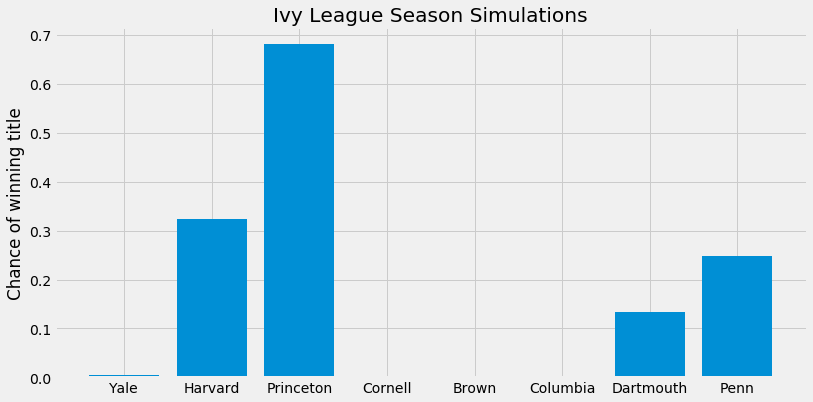

In [72]:
plt.figure(figsize=(12,6))

labels = list(ivy_titles_dict.keys())
x_pos = np.arange(len(labels))
heights = [x/10000.0 for x in list(ivy_titles_dict.values())]

plt.bar(x_pos, heights, align='center')
plt.xticks(x_pos, labels)
plt.ylabel('Chance of winning title')
plt.title('Ivy League Season Simulations')
 
plt.show()